In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import cv2
import os

In [4]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [5]:
latent_dim = 128
image_size = 128
images = []

In [6]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return []

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(
        grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(40,40)
    )

    crops = []
    for (x, y, w, h) in faces:
        x_max = min(img.shape[1], x + w)
        y_max = min(img.shape[0], y + h)
        x = max(0, x)
        y = max(0, y)

        if w <= 0 or h <= 0:
            continue

        im_cropped = img[y:y_max, x:x_max]
        if im_cropped.size == 0:
            continue

        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
        im_cropped = im_cropped.astype("float32") / 255.0
        crops.append(im_cropped)

    return crops

In [7]:
i = 0
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= 13000:
            break
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            processed_crops = preprocess_image(img_path)
            if len(processed_crops) == 0:
                continue
            for crop in processed_crops:
                images.append(crop)
                i += 1
                if i >= 13000:
                    break

In [8]:
!pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (10400, 128, 128, 3)
Test shape: (2600, 128, 128, 3)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-24 15:15:07.583829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 15:15:07.622489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 15:15:19.884734: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
from keras.saving import register_keras_serializable

encoder_inputs = keras.Input(shape=(128, 128, 3))

x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


@register_keras_serializable()
def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


I0000 00:00:1763993725.064233  158694 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7200 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,097,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,260,640 (8.62 MB)

 Trainable params: 2,260,640 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder_inputs = Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 128))(x)

# UpSampling + Conv blocks (reduce checkerboard / mejora detalles)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Salida final en [0,1] usando sigmoid (más directo para MAE/MSE)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

/home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302,627 (4.97 MB)

 Trainable params: 1,302,147 (4.97 MB)

 Non-trainable params: 480 (1.88 KB)

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

beta = 0.0001
gamma = 0.1  # peso de la perceptual loss

# --- Preparar modelo VGG para perceptual loss ---
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
layer_names = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)

def perceptual_loss(x_true, x_pred):
    # VGG espera imágenes en [0,255], actualmente tus imágenes están en [0,1]
    x_true_pp = preprocess_input(x_true * 255.0)
    x_pred_pp = preprocess_input(x_pred * 255.0)
    
    features_true = vgg_model(x_true_pp)
    features_pred = vgg_model(x_pred_pp)
    
    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += tf.reduce_mean(tf.square(f_true - f_pred))
    return loss

# --- Clase VAE ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)  # [0,1]

            # Reconstrucción MAE + SSIM
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            ssim_loss = 1.0 - ssim
            recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

            # KL divergence
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            # Perceptual loss
            p_loss = perceptual_loss(x, reconstruction)

            total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def test_step(self, x):
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)

        mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
        ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
        ssim_loss = 1.0 - ssim
        recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        p_loss = perceptual_loss(x, reconstruction)
        total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def call(self, x):
        _, _, z = self.encoder(x)
        return self.decoder(z)

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=None)

In [15]:
class SaveEveryN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            vae.build((None,) + x_train.shape[1:])
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"../Models/Temp/vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"../Models/Temp/vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f'../Models/Temp/vae_weights_epoch_{epoch+1}.weights.h5')

In [16]:
# Train the vae
epochs = 20
batch_size = 128

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=[SaveEveryN()]
)
vae.build((None,) + x_train.shape[1:])


Epoch 1/20


2025-11-24 15:15:30.691168: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cacd4002db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 15:15:30.691184: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-24 15:15:30.795339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 15:15:31.003747: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-24 15:15:31.004224: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-24 15:15:31.004569: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-24 15:15:31.005026: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignor

81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - kl_loss: 36652.4196 - loss: 14431.0975 - perceptual_loss: 144269.7133 - reconstruction_loss: 0.4607

2025-11-24 15:16:19.665344: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-24 15:16:19.665463: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-24 15:16:19.665570: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-24 15:16:19.665631: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-24 15:16:20.151533: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 15:16:20.151599: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - kl_loss: 36344.3632 - loss: 14398.9287 - perceptual_loss: 143948.3355 - reconstruction_loss: 0.4605

2025-11-24 15:16:32.628468: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-24 15:16:32.629245: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-24 15:16:32.629586: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-24 15:16:32.629857: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-24 15:16:36.271594: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-24 15:16:36.271725: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-24 15:16:36.271839: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-24 15:16:36.271896: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator S

82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 482ms/step - kl_loss: 11391.7949 - loss: 11793.2549 - perceptual_loss: 117916.7344 - reconstruction_loss: 0.4419 - val_kl_loss: 11254.9170 - val_loss: 11815.2295 - val_perceptual_loss: 118136.7344 - val_reconstruction_loss: 0.4303
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - kl_loss: 1047.6846 - loss: 9878.7822 - perceptual_loss: 98782.9531 - reconstruction_loss: 0.3813 - val_kl_loss: 1025.3762 - val_loss: 12605.2041 - val_perceptual_loss: 126047.0078 - val_reconstruction_loss: 0.4001
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - kl_loss: 673.5790 - loss: 9344.2041 - perceptual_loss: 93437.7031 - reconstruction_loss: 0.3659 - val_kl_loss: 804.3284 - val_loss: 11898.8164 - val_perceptual_loss: 118983.5625 - val_reconstruction_loss: 0.3791
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - kl_loss: 758.0943 - loss: 10399.6025 - perceptual_loss: 103991.7812 - reconstruction_loss: 0.3483 - val_kl_loss: 698.7766 - val_loss: 10949.2080 - 

In [17]:
vae.encoder.save( "../Models/vae_encoder.keras")
vae.decoder.save( "../Models/vae_decoder.keras")

vae.save_weights('../Models/vae_weights.weights.h5')

In [18]:
# encoder = keras.models.load_model("../Models/vae_encoder_300epochs.keras", compile=False, safe_mode=False)
# decoder = keras.models.load_model("../Models/vae_decoder_300epochs.keras", compile=False, safe_mode=False)

# vae = VAE(encoder, decoder)

# vae.build((None,) + x_train.shape[1:])
# vae.load_weights("../Models/vae_weights_300epochs.weights.h5")

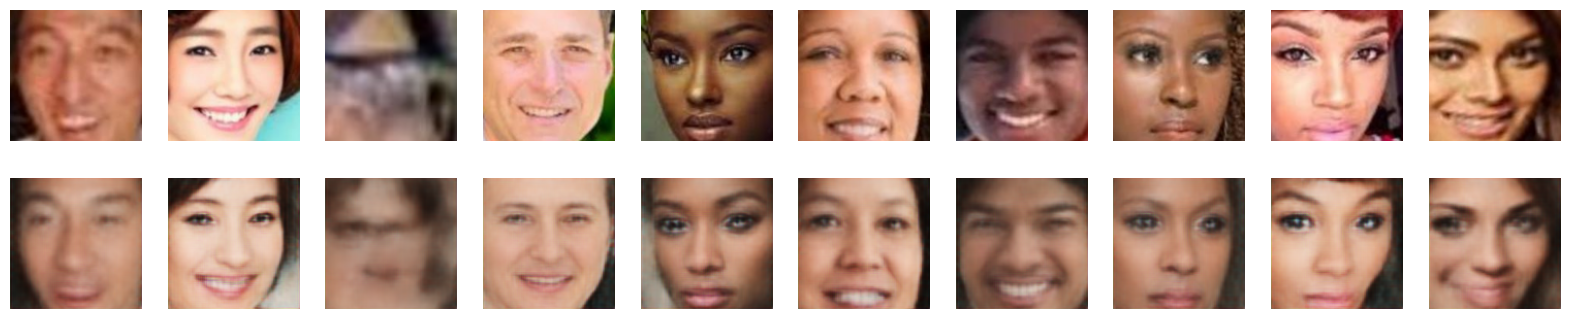

In [31]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt

n = 10

# El encoder devuelve: z_mean, z_log_var, z
z_mean, z_log_var, z = vae.encoder(x_test[:n])
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")

plt.show()

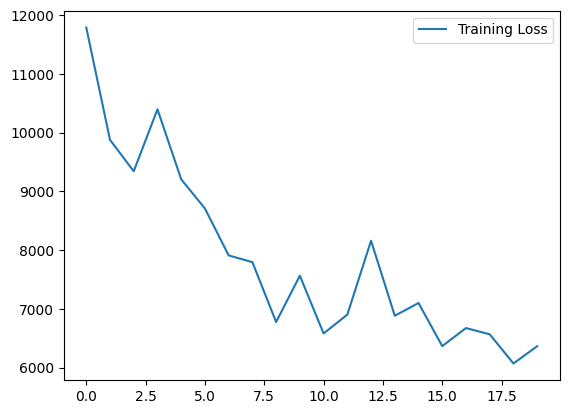

In [32]:
loss = history.history['loss']

epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')
plt.legend()
plt.show()

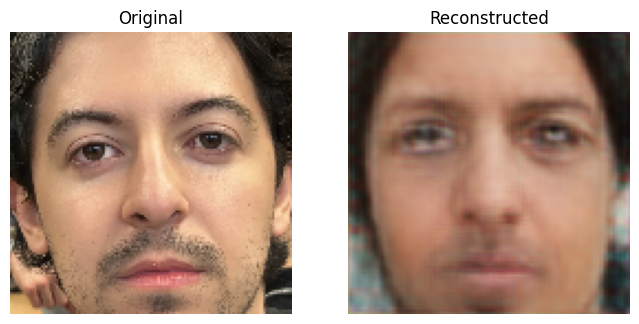

In [41]:
img_path = "../Images/JJ.jpg"

# Preprocess
face = preprocess_image(img_path)[0]
face_batch = np.expand_dims(face, axis=0)  # shape (1, H, W, C)

# Encode & decode
z_mean, z_log_var, z = vae.encoder(face_batch)
decoded_imgs = vae.decoder(z)  # still a batch of 1

# Plot original vs reconstructed
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(face)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[0])
plt.title("Reconstructed")
plt.axis("off")

plt.show()